<a href="https://colab.research.google.com/github/EJcoding/HackUTD2024_EOG/blob/main/Final_EOG_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Valiant_505H-09_22-09_30.csv
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Steadfast_505H-10_30-11_07.csv
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Ruthless_745H-10_01-10_08.csv
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Resolute_728H-10_14-10_21.csv
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Noble_4H-10_24-10_29.csv
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Gallant_102H-10_04-10_11.csv
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Fearless_709H-10_31-11_07.csv
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Courageous_729H-09_25-09_28.csv
!wget https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Bold_744H-10_31-11_07.csv

--2024-11-17 17:10:46--  https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Valiant_505H-09_22-09_30.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69925 (68K) [text/plain]
Saving to: ‘Valiant_505H-09_22-09_30.csv’

Valiant_505H-09_22- 100%[===================>]  68.29K  --.-KB/s    in 0.02s   

2024-11-17 17:10:46 (3.09 MB/s) - ‘Valiant_505H-09_22-09_30.csv’ saved [69925/69925]

--2024-11-17 17:10:46--  https://raw.githubusercontent.com/nihaal419/HackUTD-RippleEffect/refs/heads/main/data/Steadfast_505H-10_30-11_07.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.1

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
from tabulate import tabulate

In [ ]:
def fix_missing_values(file_path):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

    # Fill missing column values using forward fill, then fill remaining NaN with backward fill
    df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
    df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
    df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')

    output_file_path = file_path.replace(".csv", "_fixed_values.csv")
    df.to_csv(output_file_path, index=False)
    print(f"Updated dataset saved to {output_file_path}")
    return output_file_path

In [ ]:
def add_synthetic_ground_truth(df, anomaly_fraction=0.1):
    np.random.seed(42)

    # Create synthetic ground truth: 0 for normal, 1 for anomaly
    df["Ground_Truth"] = 0
    anomaly_indices = df.sample(frac=anomaly_fraction).index
    df.loc[anomaly_indices, "Ground_Truth"] = 1
    return df

In [ ]:
def find_anomalies(file_path):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return

    if 'Time' not in df.columns:
        print(f"Time column not found in file: {file_path}")
        return

    time_column = df['Time']
    df = df.drop(columns=["Time"])

    df = add_synthetic_ground_truth(df)
    ground_truth = df['Ground_Truth']
    df = df.drop(columns=["Ground_Truth"])

    # Feature Engineering
    df["Volume_Diff"] = (df["Inj Gas Meter Volume Instantaneous"] - df["Inj Gas Meter Volume Setpoint"])
    df["Valve_Change"] = df["Inj Gas Valve Percent Open"].diff().fillna(0)
    df["Volume_Change"] = df["Inj Gas Meter Volume Instantaneous"].diff().fillna(0)

    # Filling any remaining NaNs with 0
    features = df[["Volume_Diff", "Valve_Change", "Volume_Change"]].fillna(0)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.3, random_state=42, stratify=ground_truth)

    # Train Isolation Forest Model on the training set
    model = IsolationForest(contamination=0.1, random_state=42)
    model.fit(X_train)

    test_predictions = model.predict(X_test)

    # Convert Isolation Forest output (-1 for anomaly, 1 for normal) to binary (1 for anomaly, 0 for normal)
    y_pred = [1 if x == -1 else 0 for x in test_predictions]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Metrics for file {file_path}:")
    print(f"Accuracy: {accuracy:.2f}")
    #print(f"F1 Score: {f1:.2f}")

    # Predict anomalies for the entire dataset
    df["Anomaly"] = model.fit_predict(features)
    df["Anomaly"] = df["Anomaly"].apply(lambda x: 1 if x == -1 else 0)

    # Modify anomaly column: if volume difference < 0 and anomaly is > 0, multiply anomaly by -1
    df.loc[(df["Volume_Change"] < 0) & (df["Anomaly"] > 0), "Anomaly"] *= -1

    # Add the 'Time' column back to the dataframe
    df["Time"] = time_column

    output_file_path = file_path.replace(".csv", "_anomaly_detected.csv")
    df.to_csv(output_file_path, index=False)
    print(f"Updated dataset saved to {output_file_path}")
    return output_file_path

In [ ]:
def find_hydrate_formations(file_path):
    # Load the dataset
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return

    # Filter the rows where the Anomaly value is -1
    df_hydrates = df[df['Anomaly'] == -1]

    df_hydrates = df_hydrates.drop(columns=['Anomaly'])
    columns = ['Time'] + [col for col in df_hydrates.columns if col != 'Time']
    df_hydrates = df_hydrates[columns]

    print("Hydrate Detection")
    print(tabulate(df_hydrates, headers='keys', tablefmt='pretty', showindex=False))

    return df_hydrates


In [ ]:
def find_potential_for_hydrates(file_path):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return

    # Filter the rows where the Anomaly value is 1
    df_pHydrates = df[df['Anomaly'] == 1]

    df_pHydrates = df_pHydrates.drop(columns=['Anomaly'])
    columns = ['Time'] + [col for col in df_pHydrates.columns if col != 'Time']
    df_pHydrates = df_pHydrates[columns]

    print("Hydrate Warnings")
    print(tabulate(df_pHydrates, headers='keys', tablefmt='pretty', showindex=False))

    return df_pHydrates

In [ ]:
def plot_anomalies(file_path):
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return

    if 'Time' not in data.columns:
        print(f"Time column not found in file: {file_path}")
        return

    data['Time'] = pd.to_datetime(data['Time'], format='%m/%d/%Y %I:%M:%S %p')

    # Anomaly < 0 indicates hydrate has formed, > 0 indicates hydrate will form
    anomalies = data[data['Anomaly'] != 0]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Time'], data['Inj Gas Meter Volume Instantaneous'], label='Inj Gas Meter Volume Instantaneous', color='blue')
    plt.plot(data['Time'], data['Inj Gas Meter Volume Setpoint'], label='Inj Gas Meter Volume Setpoint', color='green')
    plt.plot(data['Time'], data['Inj Gas Valve Percent Open'], label='Inj Gas Valve Percent Open', color='orange')

    # Highlight anomalies
    plt.scatter(anomalies['Time'], anomalies['Inj Gas Meter Volume Instantaneous'], color='red', label='Anomaly', zorder=5)

    plt.xlabel('Time')
    plt.ylabel('Volume / Valve Percent')
    plt.title('Inj Gas Meter Volume Instantaneous vs Setpoint over Time')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d/%Y %I:%M:%S %p'))  # Custom date-time format
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    find_hydrate_formations(file_path)
    find_potential_for_hydrates(file_path)



In [ ]:
def main(file_path):
  a = fix_missing_values(file_path)
  b = find_anomalies(a)
  plot_anomalies(b)

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Updated dataset saved to /content/Courageous_729H-09_25-09_28_fixed_values.csv
Metrics for file /content/Courageous_729H-09_25-09_28_fixed_values.csv:
Accuracy: 0.81
F1 Score: 0.08
Updated dataset saved to /content/Courageous_729H-09_25-09_28_fixed_values_anomaly_detected.csv


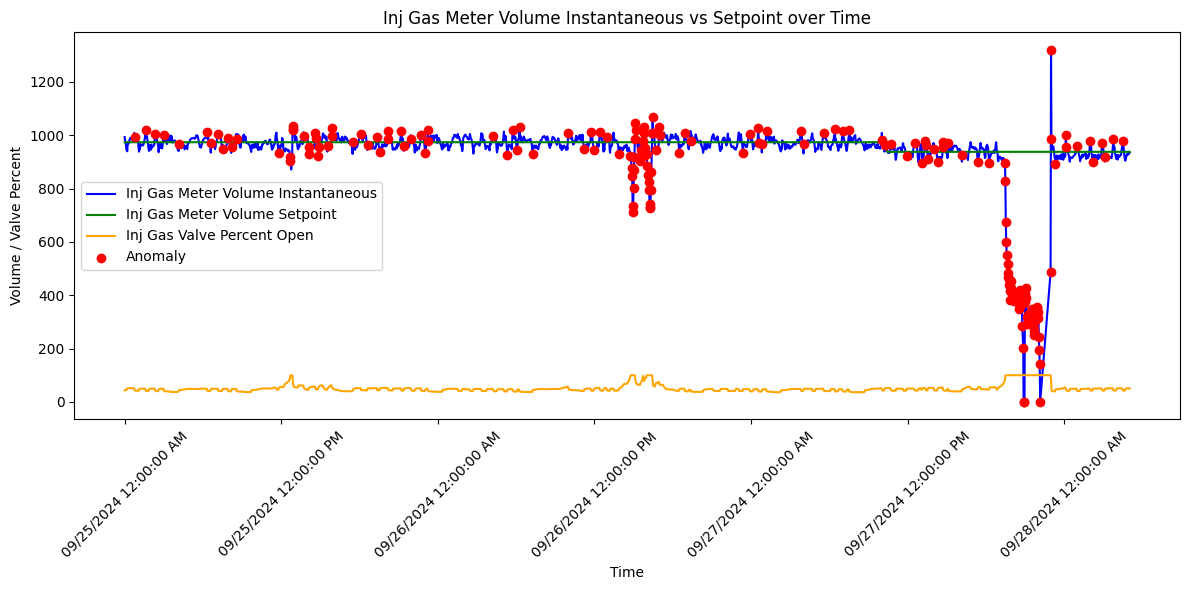

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 09/25/2024 12:46:00 am |             991.934625             |             973.5             |          43.57415          | 18.434624999999983  | -5.922124999999994  | -16.657575000000065 |
| 09/25/2024 7:56:00 am  |              989.5713              |             973.5             |          40.4492           |  16.07129999999995  |      -7.21602       | -4.731825000000072  |
| 09/25/2024 8:36:00 am  | 

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Metrics for file /content/Bold_744H-10_31-11_07_fixed_values.csv:
Accuracy: 0.85
F1 Score: 0.25
Updated dataset saved to /content/Bold_744H-10_31-11_07_fixed_values_anomaly_detected.csv


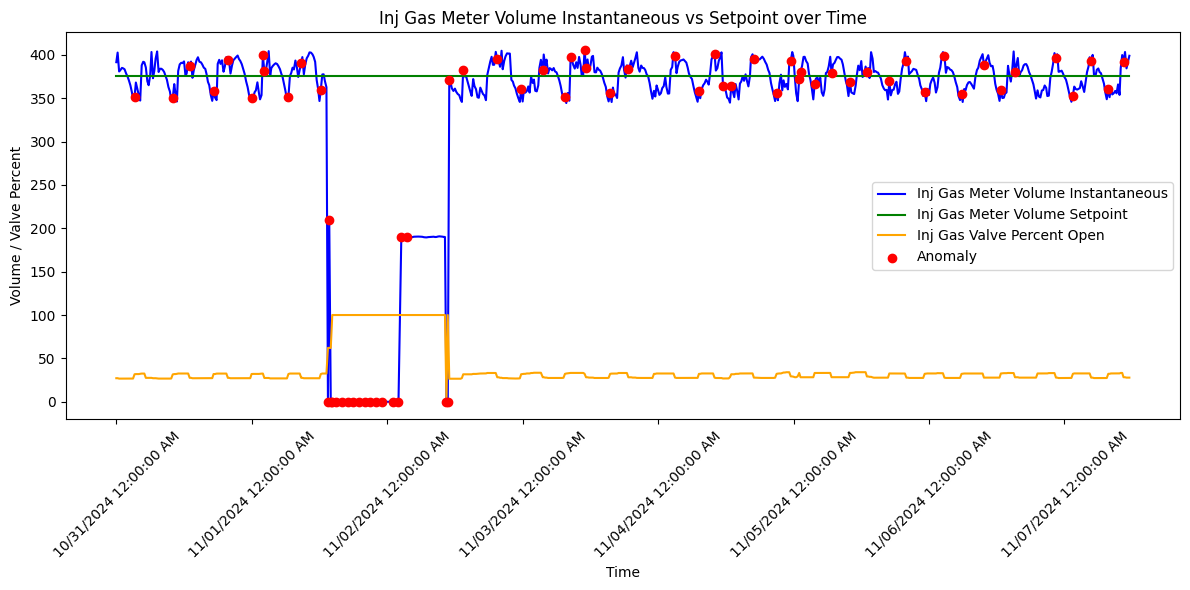

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 10/31/2024 1:00:00 pm  |             387.04995              |             375.0             |          27.59917          | 12.049950000000024  | -4.990960000000001  | -4.312349999999981  |
| 10/31/2024 7:46:00 pm  |             394.23855              |             375.0             |          27.56656          |  19.23854999999997  | -4.959599999999998  | -3.049350000000004  |
| 11/01/2024 2:14:00 am  | 

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Metrics for file /content/Fearless_709H-10_31-11_07_fixed_values.csv:
Accuracy: 0.83
F1 Score: 0.10
Updated dataset saved to /content/Fearless_709H-10_31-11_07_fixed_values_anomaly_detected.csv


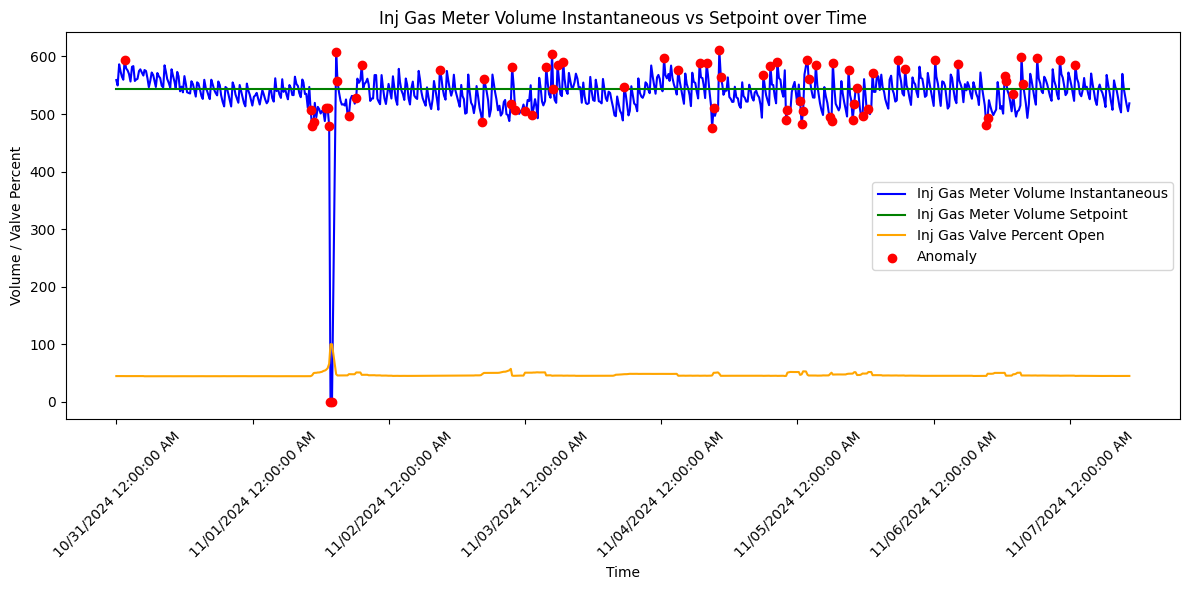

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 11/01/2024 10:14:00 am |              506.2011              |             543.0             |          44.5238           |      -36.7989       | 0.1065200000000032  | -40.80600000000004  |
| 11/01/2024 10:30:00 am |              479.0652              |             543.0             |          45.99658          |      -63.9348       | 1.4727800000000002  | -27.135899999999992 |
| 11/01/2024 1:30:00 pm  | 

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Metrics for file /content/Resolute_728H-10_14-10_21_fixed_values.csv:
Accuracy: 0.82
F1 Score: 0.09
Updated dataset saved to /content/Resolute_728H-10_14-10_21_fixed_values_anomaly_detected.csv


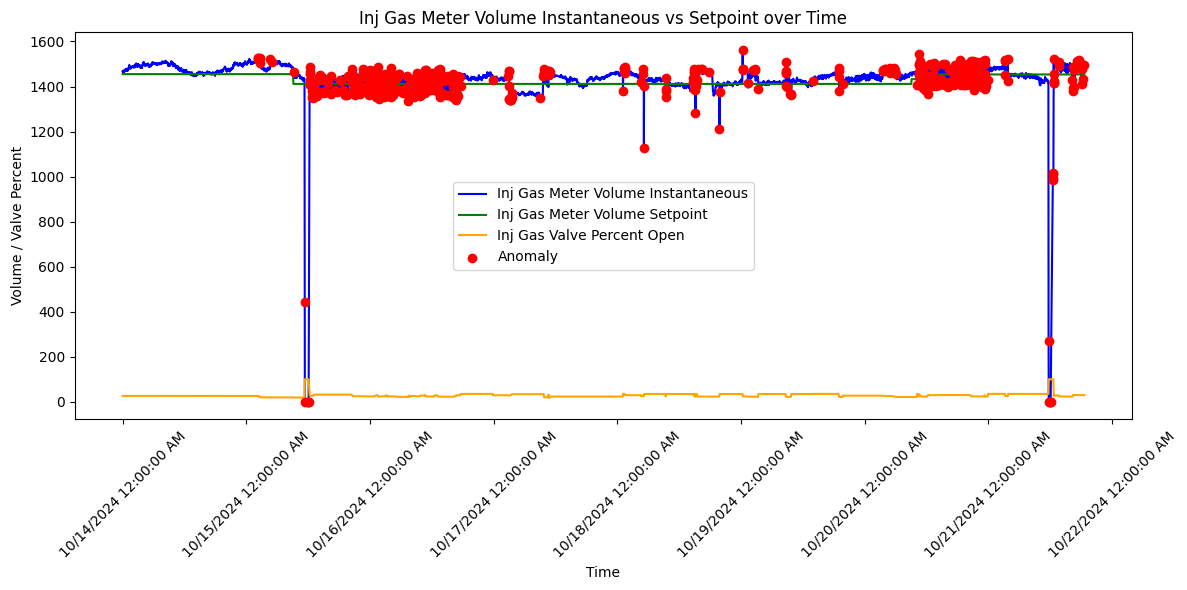

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 10/15/2024 2:20:00 am  |             1520.16525             |            1455.0             |          23.29594          |  65.16525000000001  | -1.844739999999998  | -6.150750000000016  |
| 10/15/2024 2:28:00 am  |             1519.00875             |            1455.0             |          23.03782          |  64.00874999999996  | -0.2581200000000017 | -3.7792500000000473 |
| 10/15/2024 2:42:00 am  | 

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Updated dataset saved to /content/Gallant_102H-10_04-10_11_fixed_values.csv
Metrics for file /content/Gallant_102H-10_04-10_11_fixed_values.csv:
Accuracy: 0.79
F1 Score: 0.07
Updated dataset saved to /content/Gallant_102H-10_04-10_11_fixed_values_anomaly_detected.csv


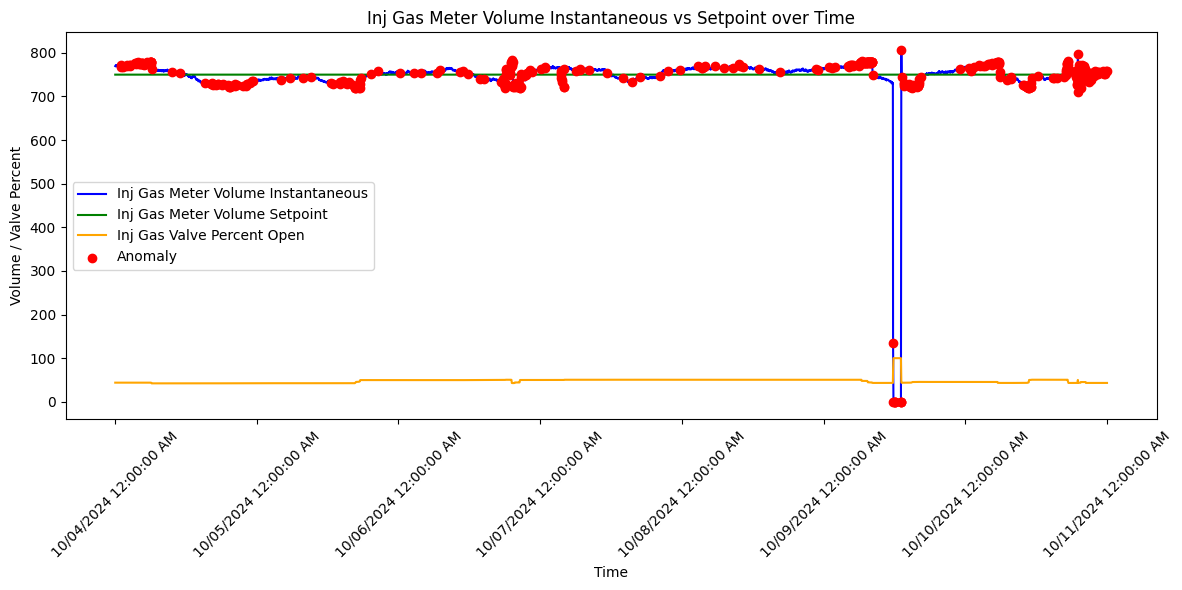

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 10/04/2024 12:56:00 am |         771.4329749999999          |             750.0             |          43.85132          | 21.432974999999946  | 0.0063650000000023  | -1.5360000000000582 |
| 10/04/2024 12:58:00 am |         767.9096999999999          |             750.0             |          43.85885          |  17.90969999999993  | 0.0075299999999955  | -3.5232750000000124 |
| 10/04/2024 1:58:00 am  | 

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Metrics for file /content/Noble_4H-10_24-10_29_fixed_values.csv:
Accuracy: 0.82
F1 Score: 0.09
Updated dataset saved to /content/Noble_4H-10_24-10_29_fixed_values_anomaly_detected.csv


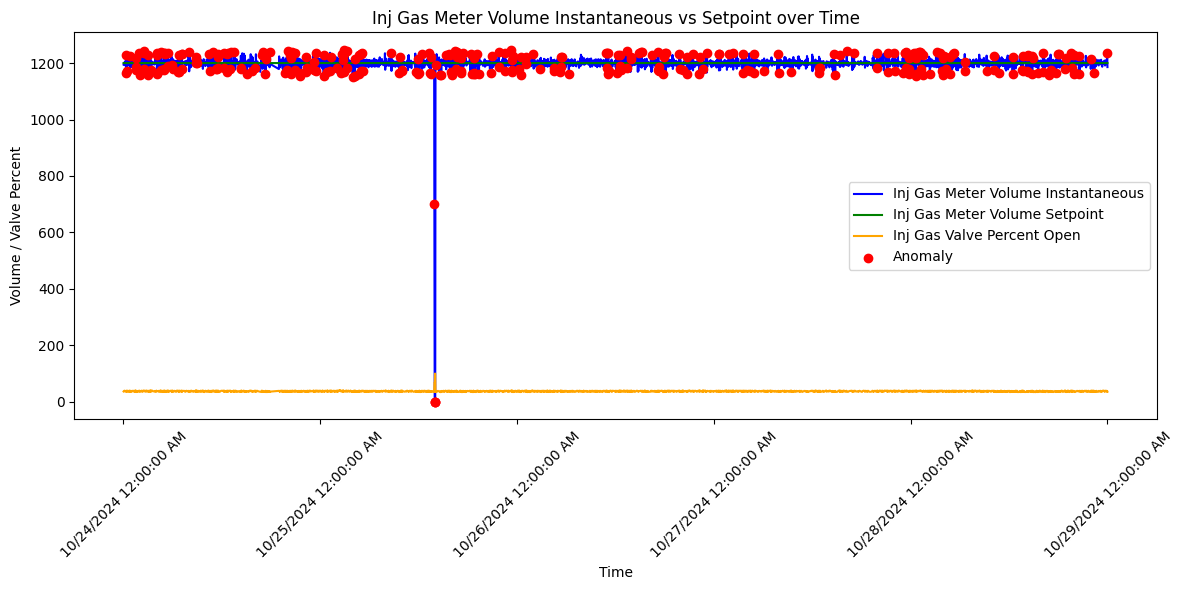

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 10/24/2024 12:20:00 am |             1166.25975             |            1200.0             |          36.53151          | -33.74025000000006  | -2.369455000000002  | -42.87885000000006  |
| 10/24/2024 12:24:00 am |             1173.02475             |            1200.0             |          36.01077          | -26.97524999999996  |      -2.04336       | -54.91409999999996  |
| 10/24/2024 1:30:00 am  | 

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Metrics for file /content/Ruthless_745H-10_01-10_08_fixed_values.csv:
Accuracy: 0.82
F1 Score: 0.08
Updated dataset saved to /content/Ruthless_745H-10_01-10_08_fixed_values_anomaly_detected.csv


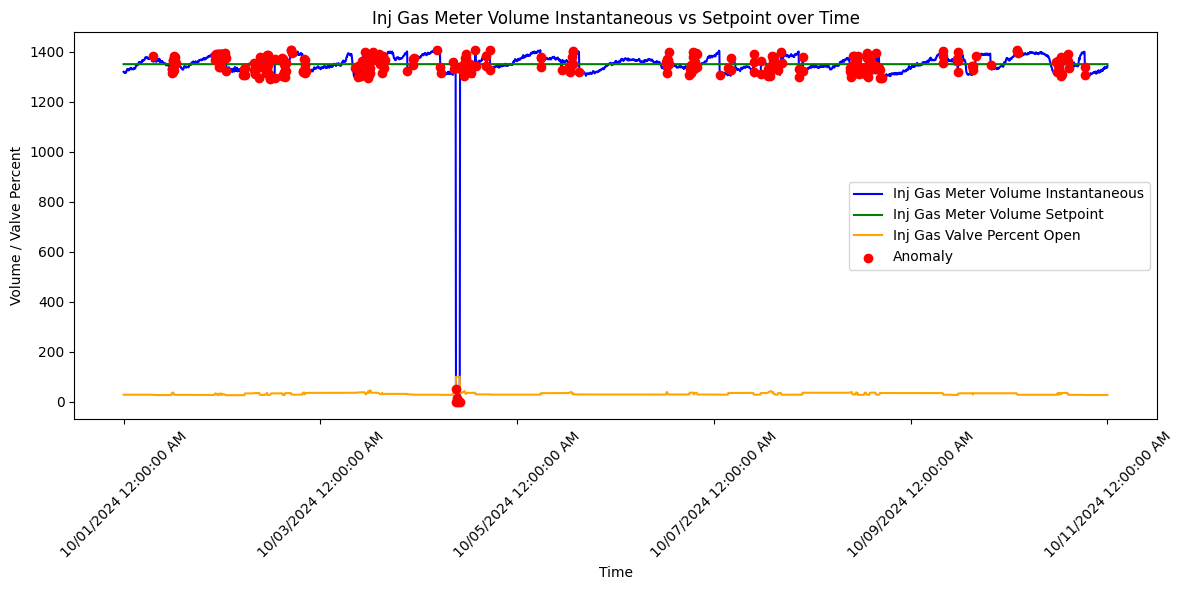

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 10/01/2024 11:45:00 am |            1315.946325             |            1350.0             |          34.07941          | -34.05367500000011  |  7.144810000000003  | -17.773975000000746 |
| 10/01/2024 11:55:00 am |             1328.6619              |            1350.0             |         35.900435          | -21.33809999999994  | 1.2283650000000037  | -2.629199999999855  |
| 10/01/2024 12:00:00 pm | 

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Metrics for file /content/Steadfast_505H-10_30-11_07_fixed_values.csv:
Accuracy: 0.83
F1 Score: 0.09
Updated dataset saved to /content/Steadfast_505H-10_30-11_07_fixed_values_anomaly_detected.csv


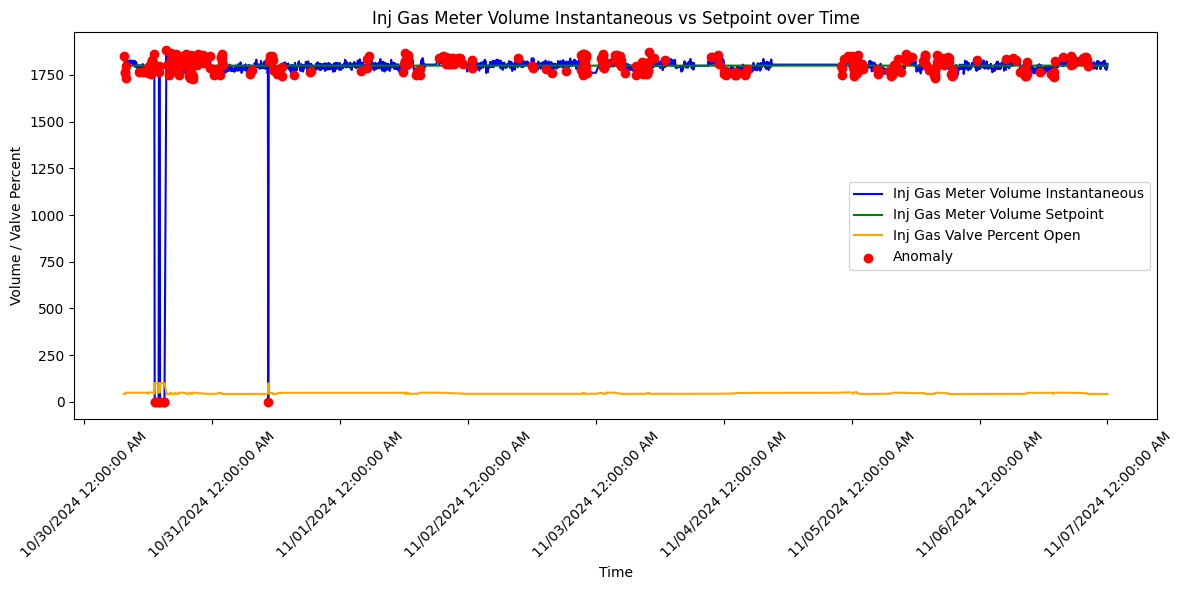

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 10/30/2024 7:38:00 am  |              1768.491              |            1800.0             |          42.08155          | -31.50900000000001  | -0.6637600000000035 | -66.90599999999995  |
| 10/30/2024 7:40:00 am  |             1758.8685              |            1800.0             |          42.77792          | -41.13149999999996  | 0.6963700000000017  | -9.622499999999944  |
| 10/30/2024 7:48:00 am  | 

<ipython-input-15-9f8fbec6c5ae>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Valve Percent Open"] = df["Inj Gas Valve Percent Open"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Setpoint"] = df["Inj Gas Meter Volume Setpoint"].fillna(method="ffill").fillna(method='bfill')
<ipython-input-15-9f8fbec6c5ae>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Inj Gas Meter Volume Instantaneous"] = df["Inj Gas Meter Volume Instantaneous"].fillna(method="ffill").fillna(method='bfill')


Metrics for file /content/Valiant_505H-09_22-09_30_fixed_values.csv:
Accuracy: 0.82
F1 Score: 0.08
Updated dataset saved to /content/Valiant_505H-09_22-09_30_fixed_values_anomaly_detected.csv


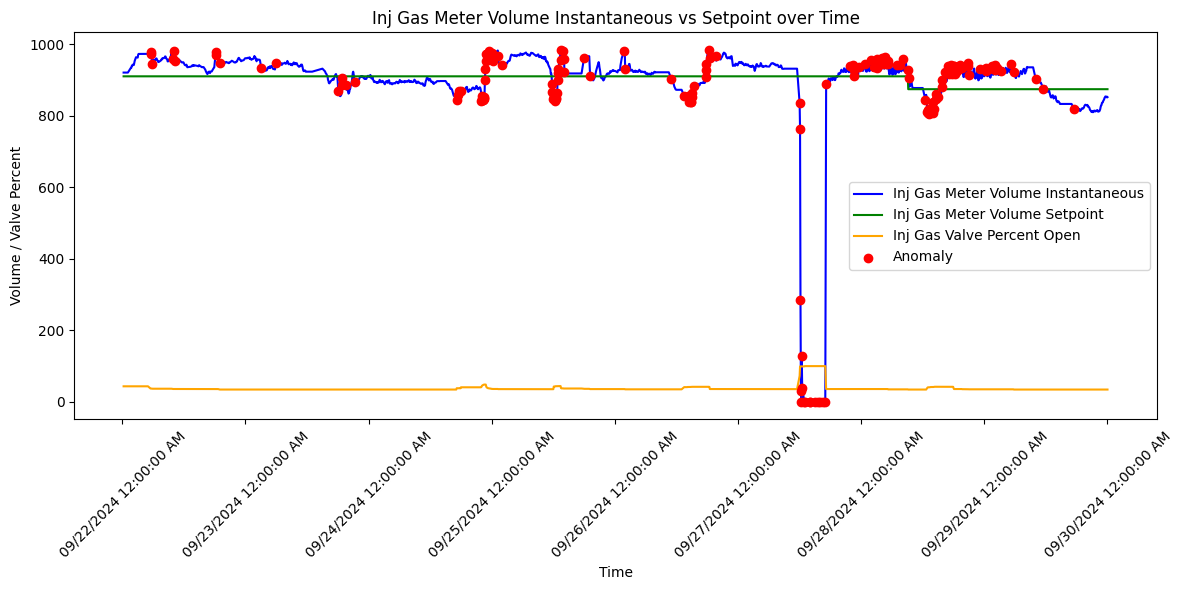

Hydrate Detection
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
|          Time          | Inj Gas Meter Volume Instantaneous | Inj Gas Meter Volume Setpoint | Inj Gas Valve Percent Open |     Volume_Diff     |    Valve_Change     |    Volume_Change    |
+------------------------+------------------------------------+-------------------------------+----------------------------+---------------------+---------------------+---------------------+
| 09/22/2024 5:50:00 am  |             944.660475             |             910.5             |          36.7808           |  34.16047500000002  | -0.5077800000000039 | -35.159850000000006 |
| 09/22/2024 9:50:00 am  |             959.09325              |             910.5             |          36.02027          |  48.59325000000001  | -0.7605300000000028 | -18.437099999999987 |
| 09/22/2024 10:15:00 am | 

In [ ]:
# Example usage: process multiple CSV files
input_csv_files = [
    '/content/Courageous_729H-09_25-09_28.csv',
    '/content/Bold_744H-10_31-11_07.csv',
    '/content/Fearless_709H-10_31-11_07.csv',
    '/content/Resolute_728H-10_14-10_21.csv',
    '/content/Gallant_102H-10_04-10_11.csv',
    '/content/Noble_4H-10_24-10_29.csv',
    '/content/Ruthless_745H-10_01-10_08.csv',
    '/content/Steadfast_505H-10_30-11_07.csv',
    '/content/Valiant_505H-09_22-09_30.csv'
]

for input_csv in input_csv_files:
    main(input_csv)

In [ ]:
# Demo usage:
file_path = input("Enter the path to the CSV file: ")
main(file_path)

KeyboardInterrupt: Interrupted by user